# Relatório Final
___
### João Guilherme Almeida

In [34]:
import subprocess
import time
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def roda_com_entrada(ex, in_f):
    with open(in_f) as f:
        start = time.perf_counter()
        proc = subprocess.run([ex], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()
        return proc.stdout, end-start, 

# Introdução

O projeto aqui presente tem o intuíto de trabalhar o problema de pareamento de sequências de DNA, ou seja, encontrar a similiaridade entre duas sequências de nucleotídeos.

Para tanto, foi se debruçado sobre diversas estratégias que buscam encontrar o melhor score possível para a similiaridade entre as sequências, essas sendo:

1. Heurística com Simth Waterman
2. Busca Local com aleatoriedade
3. Busca Exaustiva

Além disso, para aprimorar a execução, foram implementados os seguintes métodos de otimização na busca exaustiva:
1. Open MP
2. Parelização com GPU


# Gerando Arquivos de Entrada

Serão gerados diversos arquivos de entradas de tamanhos diversos. Isso pois para comparar as heuristicas é interessante que essas sejam submetidas a tamanhos diferentes de entradas para avaliar, não só a qualidade delas, como também, o tempo de execução por exemplo.

Foram criados 400 arquivos de entrada para as heuristicas ingênuas e de busca local, e a forma de fazer os arquivos para busca exaistiva será diferente. Além disso, 5 arquivos de entrada terão as duas sequencias de mesmo tamanho, porém conteúdos diferentes. Por fim, para fazer a segunda sequência maior, foi adicionado 2 ao tamanho da primeira.

In [3]:
for i in range(1, 400, 5): 
    for e in range(0,5):
        n = i
        m = i + 2
        file = "./inputs/dna{0}_{1}.seq".format(i,e)
        f = open(file, 'w')
        seq=[str(n)+'\n',
             str(m)+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
        f.close()

Os arquivos de testes são estruturados da seguinte forma:
1. A primeira e a segunda linha do arquivo gerado representam o tamanho da primeira e da segunda sequência respectivamente
2. As duas últimas representam as sequências em si

# Heuristica com Smith Wallerman

O algoritmo de Smith Wallerman se apropria de matrizes e combinações de sequências de algarismos para entregar uma nota de combinção entre estas. Esta nota é calculada através do match, missmatch e gap ou seja, quando o par de caractéres (no caso do projeto as bases nitrogenadas) são iguais, diferentes ou uma encontra uma vazia, respectivamente. É importante notar que esse algorítimo se baseia muito em exploitation.

Com os arquivos de entrada gerados, é inicializado os teste em si. Primeiramente serão analizados os resultados e duração dos testes para a heurística ingênua com a ulitazação do alagoritimo de Smith Wallerman. Para isso, foi gerado, em primeiro lugar, uma lista com o caminho dos arquivos de entrada:

In [4]:
arqs = [f'./inputs/dna{i}_{e}.seq' for i in range(1,400,5) for e in range(0,5)]

Com isso, para cada grupo de arquivos com mesmo tamanho de entradas, é realizado o teste do grupo e armazenado o tempo de execução para cada uma desta.

In [5]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_Heuristica = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada("./ingenuo/ingenuo", arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_Heuristica.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [6]:
N_Heuristica = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_Heuristica.append(n)
        contador = 0
print(N_Heuristica)


[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396]


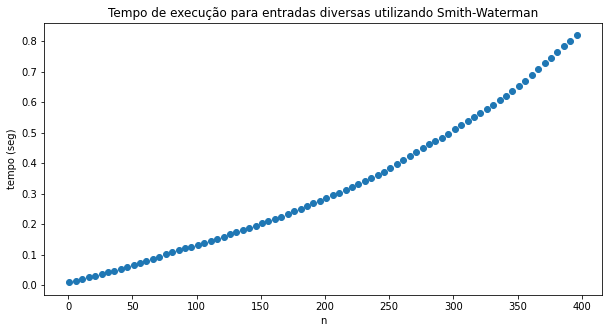

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_Heuristica, tempos_Heuristica)
plt.title("Tempo de execução para entradas diversas utilizando Smith-Waterman")
plt.show()

Observa-se que, primeiramente, que a execução da heurística ingênua é muito rápida, fazendo com que todos os 400 arquivos fossem rodados em poquissimos segundos, mesmo para uma entrada muito grande.

___

# Busca Local

Busca local é um algorítimo que se baseia mais em exploration e em pouco exploitation. Este se apropria de aleatoriedade para gerar as subsequências de diferentes tamanhos, assim através dessas sequências aleatórias calcula-se a pontuação e monta-se as sequências A e B resultantes da melhor pontuação.

Para o algorítimo de busca local, foi necessário aumentar o step de quais arquivos seriam utlizados, ou seja, diminuir o intervalo de entradas. Ainda assim, foi possível realizar o teste para entradas muito longas, com n chegando a quase 400.

In [247]:
arqs = [f'./inputs/dna{i}_{e}.seq' for i in range(1,400,15) for e in range(0,5)]

In [248]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_local = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_local/busca_local', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_local.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [249]:
N_local = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_local.append(n)
        contador = 0
print(N_local)


[1, 16, 31, 46, 61, 76, 91, 106, 121, 136, 151, 166, 181, 196, 211, 226, 241, 256, 271, 286, 301, 316, 331, 346, 361, 376, 391]


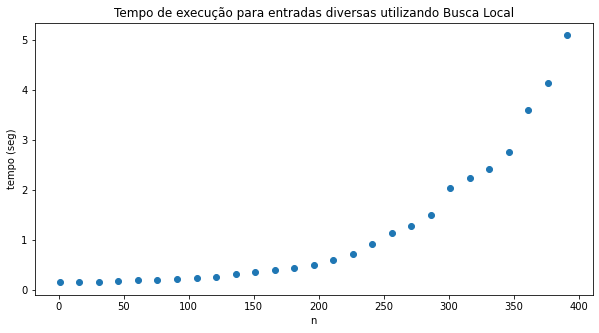

In [250]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_local, tempos_local)
plt.title("Tempo de execução para entradas diversas utilizando Busca Local")
plt.show()

Ao realizar o teste com busca local, é possível concluir que este é muito demorado. Isso se dá principalmente porque ele tem que quebrar uma das sequencias de entrada em partes menores (utilizando p e k) e testar a combinação dessas partes com a outra sequência várias vezes. Foi necessário diminuir a quantidade de vezes que o algorítimo faz diferentes quebras de 100 para 10, para que o tempo seja possível de realizar.

# Busca Exaustiva com auxílio de Smith-Waterman

Busca exaustiva é um algorítimo que foca-se muito em exploration, sendo assim este gera todas as possíveis subsequências para conseguir encontrar a melhor combinação das sequências de entrada.

Os arquivos de entrada para busca exaustiva tiveram que mudar muito. Primeiramente foi testado localmente que a demora para entradas com tamanhos maiores que 80 eram extremamente altas. Com isso, foi estabelicido que o máximo que a entrada possa ser era 70. Além disso, para não demorar muito, foi diminuido a quantidade de arquivos de entrada.

In [20]:
for i in range(5, 65, 3):
    for e in range (0,5):
        n = i
        m = i + 5
        file = "./inputs_exaust/dna{0}_{1}.seq".format(i,e)# nome do arquivo a ser gerado
        f = open(file, 'w')
        seq=[str(n)+'\n',
             str(m)+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
        f.close()

In [21]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [23]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_exaustiva/busca_exaustiva', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [24]:
N_exaust = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust.append(n)
        contador = 0
print(N_exaust)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


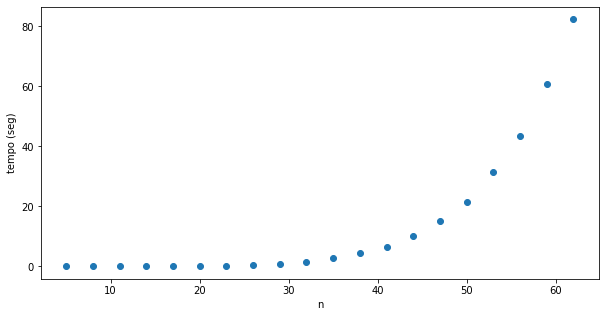

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust, tempos_exaust)
plt.show()

Busca Exaustiva é muito demorado porque além do que o busca local faz, esse quebra as duas sequências em todas as subsquências possíveis, logo tem que fazer o dobro do esforço.

___

# Busca Exaustiva com truncagem

In [6]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [7]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust_trunc = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_exaustiva/busca_exaustiva_trunc', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust_trunc.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

OSError: [Errno 8] Exec format error: './busca_exaustiva/busca_exaustiva_trunc'

In [258]:
N_exaust_trunc = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust_trunc.append(n)
        contador = 0
print(N_exaust_trunc)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


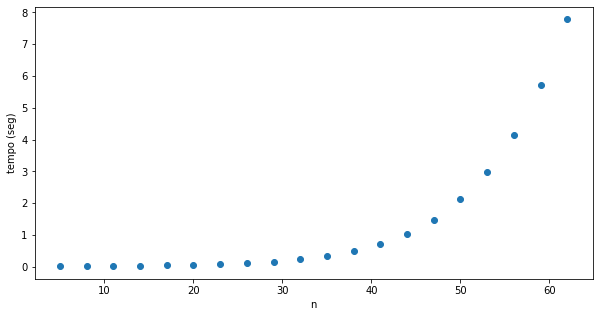

In [259]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust_trunc, tempos_exaust_trunc)
plt.show()

___

# Paralelismo CPU

Ao realizar o teste de execução com o busca exaustiva não truncado, é possível perceber que, como esperado, o algorítimo atinge o melhor score. Porém atingir tal qualidade custa caro, já que o tempo de realização deste é muito longo. Isso se dá majoritariamente por estarmos tratando sequencialmente o problema, ou seja, quebrando as sequências em todas as subsequências possíveis e fazendo o teste de comparação para cada par, uma depois da outra. 

Dessa forma, para poder diminuir o tempo de execução, vamos alterar a metodologia de sequencial para paralelizada. Primeiramente, vamos testar com a parelização na CPU, se apropriando da biblioteca OpenMP, a qual utiliza diversas threads da CPU para executar uma parte específica do programa.

A questão inicial nessa etapa seria questionar qual parte do código poderia ser paralelizado. Para responder isso, basta imaginar qual é a parte sequencial do código, que poderia ser duas partes, ou a geração das subsequências ou o cálculo do score. Em tese, o ideal para parelelizar, seria fazer ambas as etapas com OpenMP, mas vamos fazer apenas no cálculo do score e ver o quanto melhora e recomendar que uma próxima iteração seria implementar o OpenMP na criação de subsequências também.

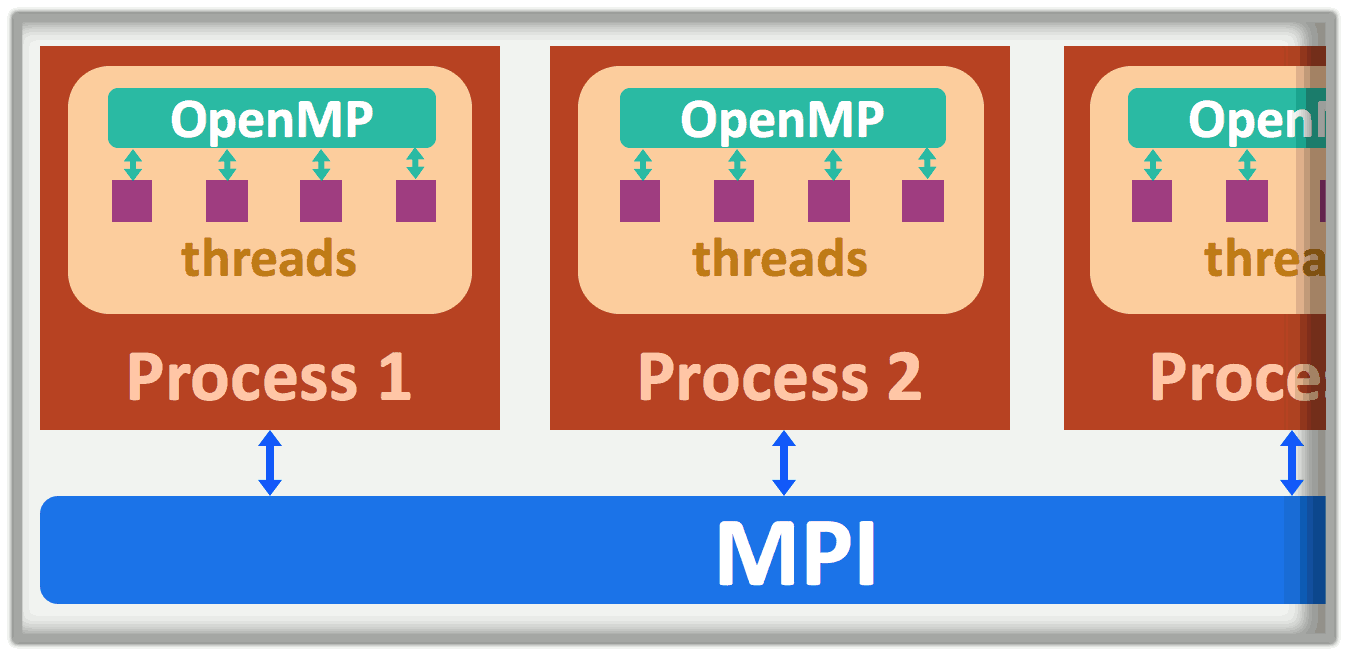

Para implementar, foi necessário criar um struc que era composto por uma variavel numérica score e duas strings subsequenciaA e subsequenciaB. Além disso, foi criado um vetor desse struct. Assim, logo antes de calcular o score das subsquencias era necessário montar esse vetor com todas as subsequencias e scores 0. Com o vetor montado, foi realizado um paralell for que usava a paralelização das threads para calcular o score das subsequencias, de maneira paralelizada 

In [8]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [26]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust_par_cpu = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./paralelismo_CPU/paralelismo_exaustivo_par', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust_par_cpu.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [27]:
N_exaust_par_cpu = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust_par_cpu.append(n)
        contador = 0
print(N_exaust_par_cpu)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


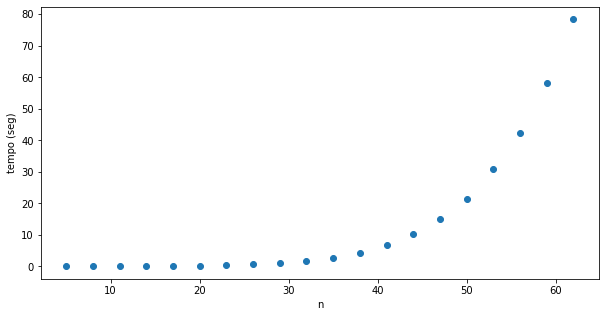

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust_par_cpu, tempos_exaust_par_cpu)
plt.show()

# Conclusão

NameError: name 'N_local' is not defined

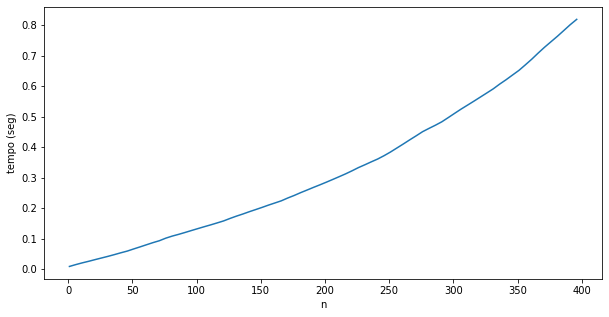

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.plot(N_Heuristica, tempos_Heuristica, label='Heuristica Ingenua')
plt.plot(N_local, tempos_local, label='Busca Local')
ax.plot(N_exaust, tempos_exaust, label='Busca Exaustiva')
plt.plot(N_exaust_trunc, tempos_exaust_trunc, label='Busca Exaustiva Trunc')
plt.legend()
plt.show()

Com o gráfico acima, é facilmente possível de perceber que o algorítimo ingênuo é o mais rápido para qualquer tamanho de entrada e o Busca Exaustiva (com o auxílio do algorítimo de Smith-Wallerman) é extremamente demorado para entradas de n grande. A crescente demora para a relização desses algorítimos (de Ingênuo para busca local, busca exaustiva truncada e busca exaustiva) se dá pelo fato de os mais demorados tem que quebrar as entradas e fazer diversas combinações a mais.

## Comparação dos resultados:

Para comparar qual algorítimo consegue atingir melhores resultados de pontução foi fixado duas entradas de tamanho 60 tanto para a primeira, quanto para a segunda sequencia

GA-C-TCC-GACACTCAGCCTTCAGGC-G-ATGCGCAT-G--TCCGTCGCA-AAGATT-G
GG-AGT-TGGCA-ATG-G-G-CGTTA-ACC--AG-TGCGCTCGGGA-AC-TCCGAGACG-

Com isso foram obtidos os resultados:

Ingênuo:

Busca local:

Busca exaustiva Smithen Wallerman

Busca exaustiva com truncamento

O ponto interessante da comparação entre os scores dos algorítimos é que o busca exaustiva teve o melhor desempenho, porém não um tão melhor quanto o ingênuo. Isso gera uma dúvida a respeito da relevância de se utilizar o busca exaustiva, já que ele é muito demorado e não possui um resultado tão melhor quanto o ingênuo. Ao mesmo tempo, seria necessário fazer mais testes. 

Além disso, algo curioso foi o resultado do algorítimo aleatório do busca local que obteve um score adequado, podendo ser bem utilizado em cenários para familiarizar com a situação e validar um score de um outro algorítimo.

Por fim, o busca exaustiva com truncamento se demonstrou muito pouco eficiente por ser demorado e possuir um desempenho de score muito ruim.

In [40]:
df = pd.DataFrame(list(zip(tempos_exaust, tempos_exaust_par_cpu)),
               columns =['Não paralelizado', 'Paralelizado'])
df

,Não paralelizado,Paralelizado
0,0.006954,0.010616
1,0.016163,0.024658
2,0.030317,0.048397
3,0.053075,0.087411
4,0.097386,0.138741
5,0.178873,0.240458
6,0.316140,0.401426
7,0.555034,0.651321
8,0.971724,1.138858
9,1.651595,1.796275


## Profiling

Realizado vallgrind com a mesma entrada acima

Ingenuo

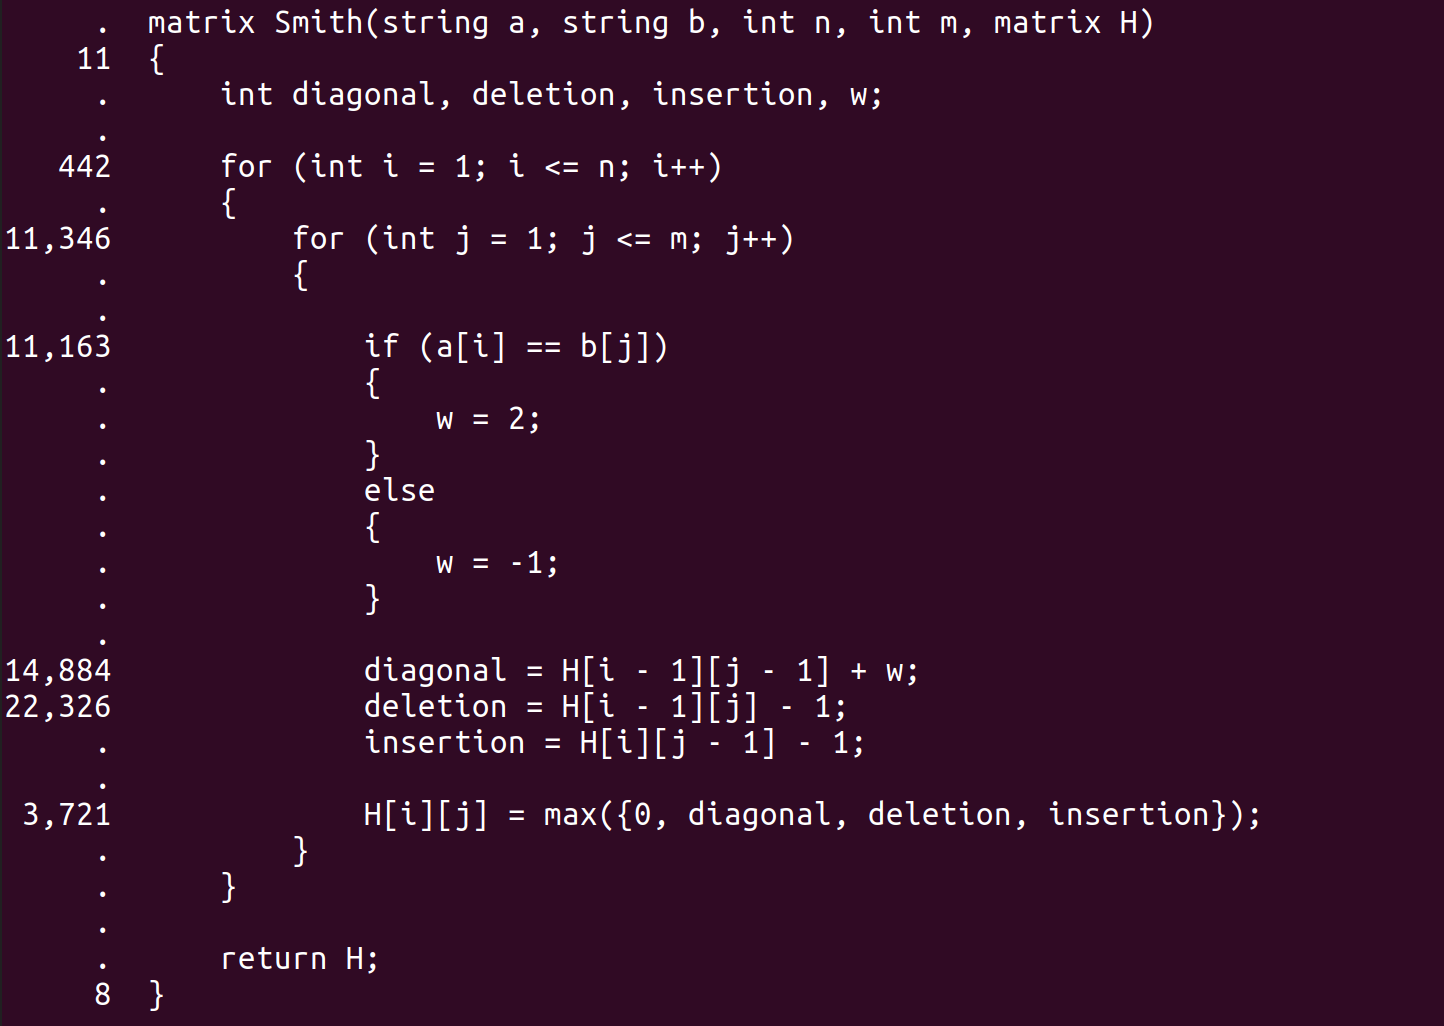

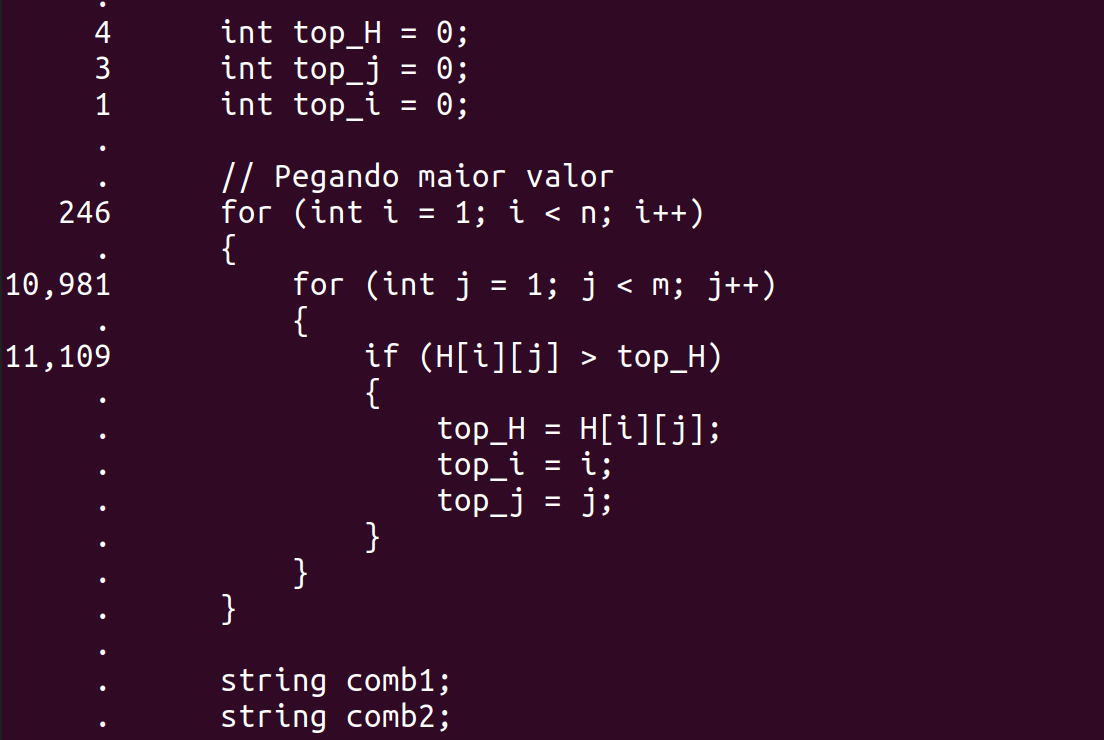

Busca Local

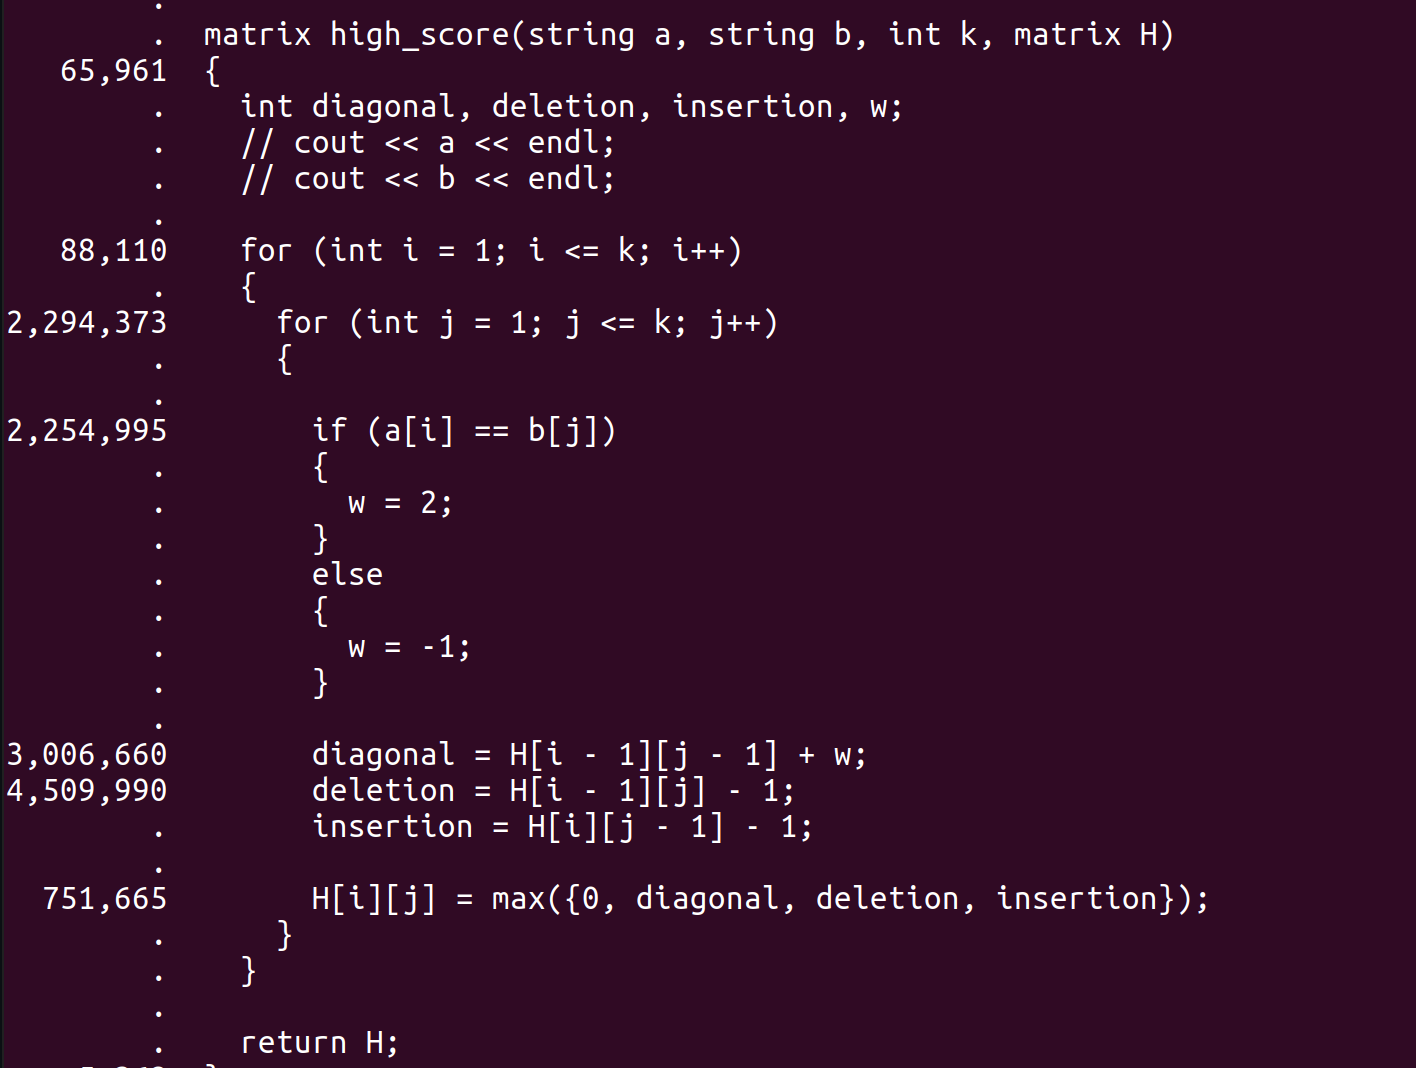

Busca Exaustiva SmithWallerman

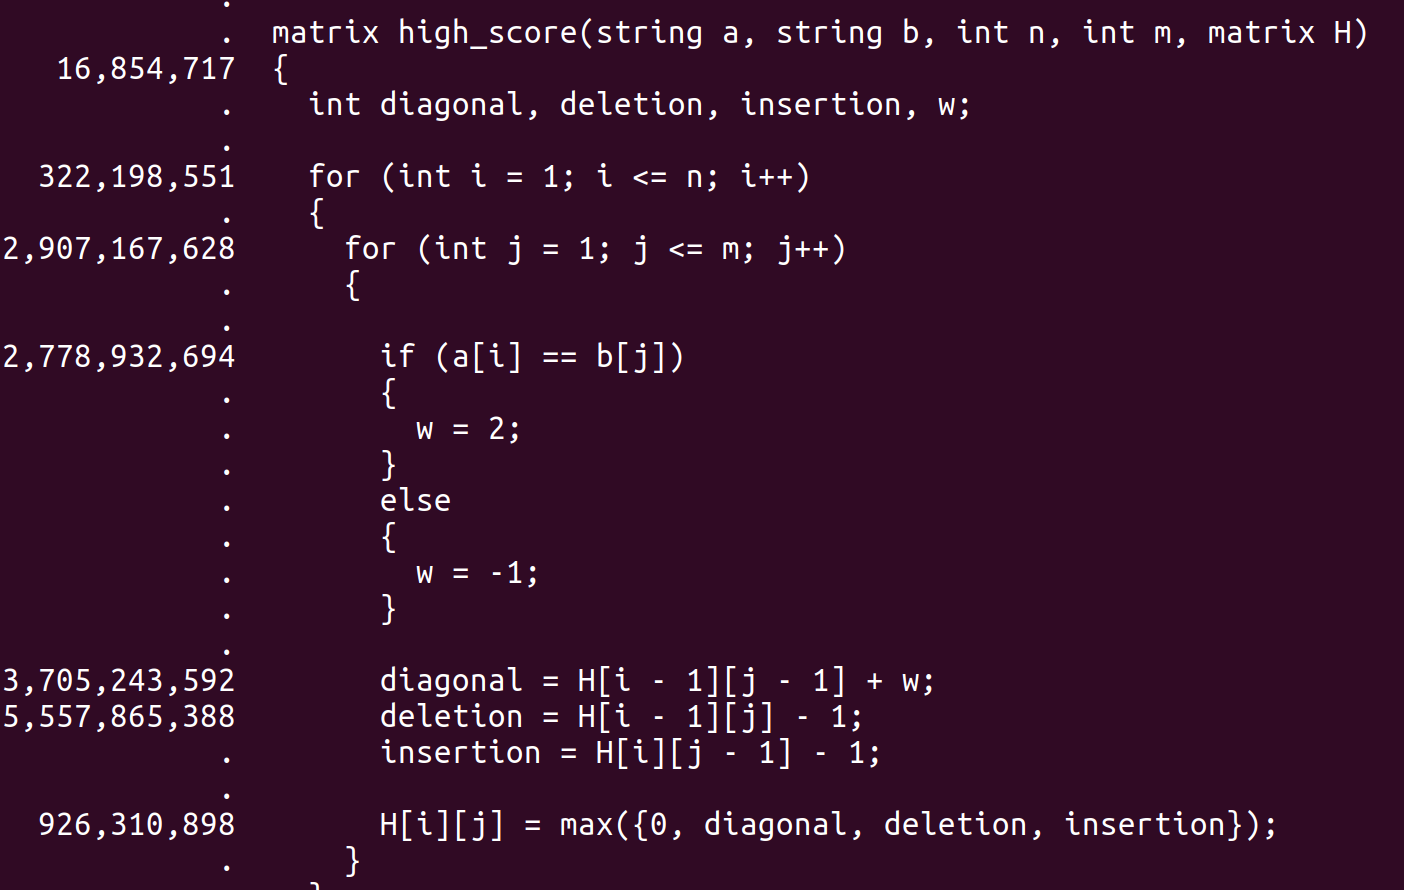

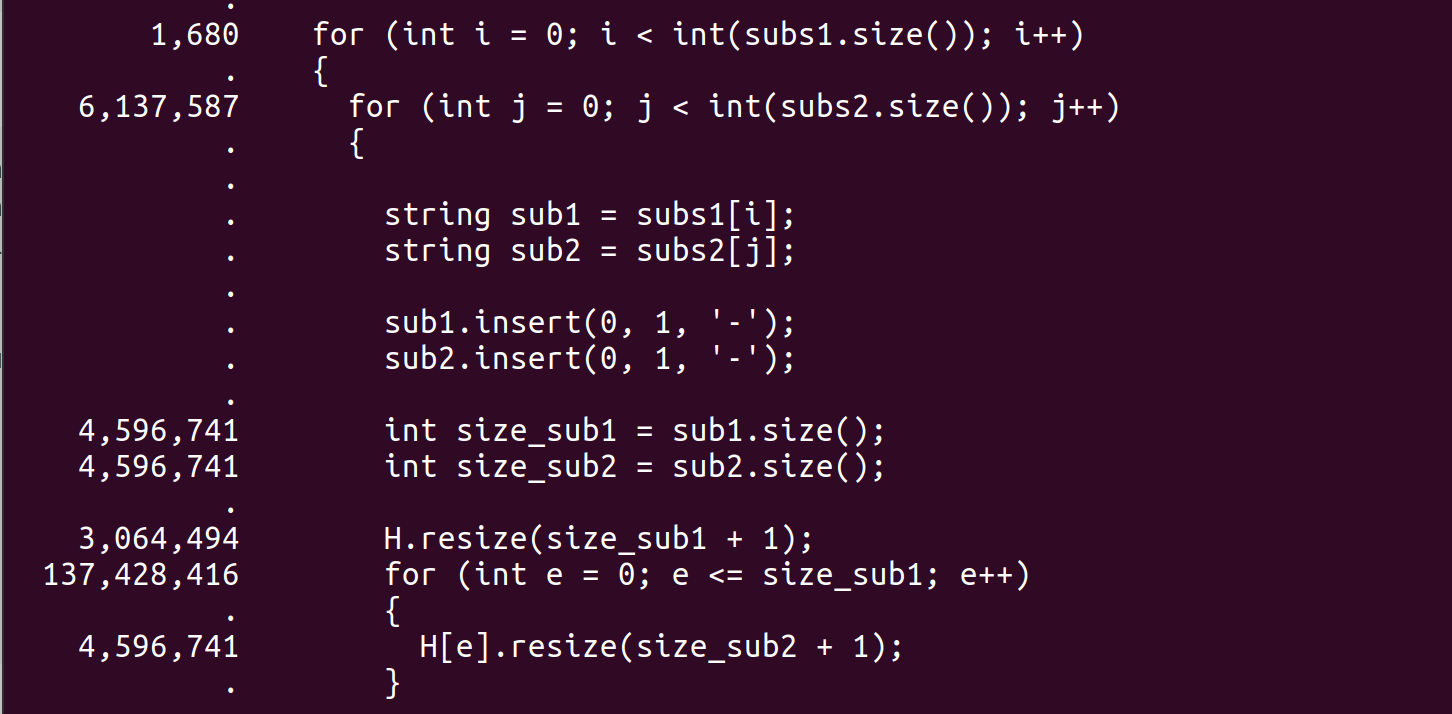

Busca Exaustiva Trunc

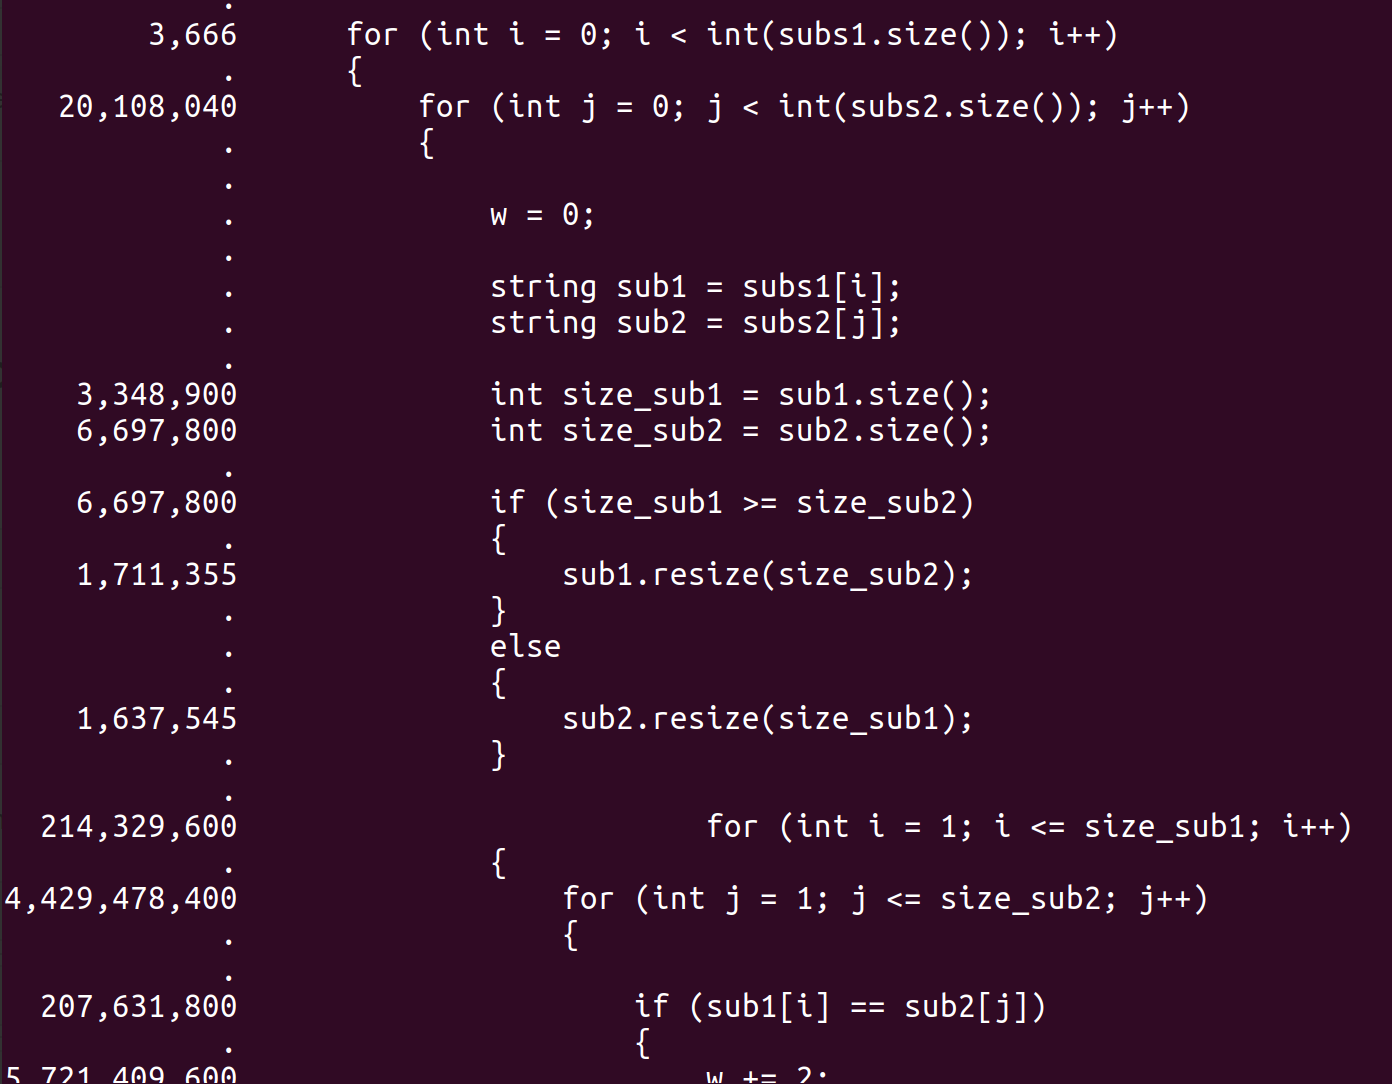

Com o uso de vallgrind é possível perceber que em todos os algorítimos o que causa maior lentidão são os fors. Esses deveriam ser evitados para melhorar a lentidão. Além disso, seria melhor se não fosse utlizado matrizes, já que muitas vezes é necessário percorrer por toda ela.